In [1]:
import numpy as np
import pandas as pd
from scipy.fftpack import fft, fftfreq, ifft
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

# FFT Algorithm

In [2]:
casesURL = "https://raw.githubusercontent.com/jgehrcke/covid-19-germany-gae/master/cases-rki-by-state.csv"
df=pd.read_csv(casesURL)

df = df.loc[:, ['time_iso8601','DE-BW']]
df["dailyChange"] =  df['DE-BW'].diff().fillna(df['DE-BW'])
df.drop(['DE-BW'], axis=1, inplace=True)

## Create my Numpy Array
df["dailyChange"] = df["dailyChange"].apply(np.int64)
npArray = np.empty(shape=(1,len(df.index)), dtype=int)
## Filling numpy array with values
for i in range (len(df.index)):
    npArray[0][i] = df['dailyChange'][i]
    
df.tail()

,time_iso8601,dailyChange
410,2021-04-16T17:00:00+0000,3271
411,2021-04-17T17:00:00+0000,2670
412,2021-04-18T17:00:00+0000,1119
413,2021-04-19T17:00:00+0000,1506
414,2021-04-20T17:00:00+0000,3311


In [3]:
## FFT algorithm
# https://gist.github.com/tartakynov/83f3cd8f44208a1856ce (Some changes were made)
def fftExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft(x_notrend)  # detrended x in frequency domain
    f = fftfreq(n)              # frequencies
    indexes = range(n)
    # sort indexes by frequency, lower -> higher
    indexes = list(range(n))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [4]:
def zeroToNan(values):
    return [float('nan') if x==0 else x for x in values]

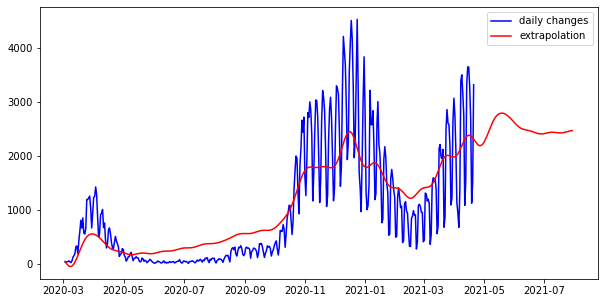

In [5]:
## How many predictions we want to make
n_predict = 100
extrapolation = fftExtrapolation(npArray[0], n_predict)
# Making antoher Daterframe with futer dates
df2 = pd.date_range(start=df['time_iso8601'][0], periods=len(df)+n_predict, freq='D')
# Adding the future values so dates index match wit x index
npTemp = np.zeros((n_predict,), dtype=int)
npAddedValues= np.concatenate((npArray[0], npTemp), axis=None)
# Change all Zeros to nan so matlatlib doesnt print ti
npAddedValues = zeroToNan(npAddedValues)
# Change figure size
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(df2, npAddedValues, 'b', label = 'daily changes', linewidth = 1.5)
plt.plot(df2, extrapolation, 'r', label = 'extrapolation')
plt.legend()
plt.show()